<a href="https://colab.research.google.com/github/Joh-Ishimwe/Data-Preprocessing/blob/master/Notebooks/Part_3_Data_Consistency_and_Quality_Checks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Integrity Checks

In [36]:
import pandas as pd
df = pd.read_csv("final_customer_data_7.csv")


 # a. Checking for duplicate entries





In [37]:
# Checking for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 10


In [38]:
# Inspecting duplicate
duplicate_rows = df[df.duplicated(keep=False)]
print(duplicate_rows)

     customer_id_legacy  transaction_id  purchase_amount  customer_rating  \
3                   101            1059       425.420569         2.408380   
7                   101            1059       425.420569         2.408380   
8                   101            1059       414.524957         2.412102   
12                  101            1059       414.524957         2.412102   
13                  101            1073       153.777922         2.025114   
17                  101            1073       153.777922         2.025114   
18                  101            1073       158.356113         1.910015   
22                  101            1073       158.356113         1.910015   
23                  101            1073       149.211286         2.241344   
27                  101            1073       149.211286         2.241344   
28                  101            1017       279.813670         2.100000   
32                  101            1017       279.813670         2.100000   

In [39]:
# dropping duplicates
df = df.drop_duplicates()
print(f"Shape after dropping duplicates: {df.shape}")

Shape after dropping duplicates: (418, 18)


# b. Ensuring all categorical values are correctly mapped.

In [40]:
# Inspecting categorical columns
print("Unique product categories:", df['product_category'].unique())
print("Unique social media platforms:", df['social_media_platform'].unique())
print("Unique review sentiments:", df['review_sentiment'].unique())

Unique product categories: ['Books' 'Clothing' 'Groceries' 'Electronics' 'Sports']
Unique social media platforms: [nan 'Twitter' 'LinkedIn' 'Instagram' 'TikTok' 'Facebook']
Unique review sentiments: [nan 'Negative' 'Neutral' 'Positive']


In [41]:
df['social_media_platform'] = df['social_media_platform'].fillna('None')
df['review_sentiment'] = df['review_sentiment'].fillna('Unknown')

# c. Validating if customer transactions match a valid social profile

In [42]:
social_rows = df[df['social_media_platform'].notna()]
print(f"Rows with social media: {len(social_rows)}")

Rows with social media: 418


In [43]:
#Check for missing engagement data
missing_engagement = social_rows[social_rows[['engagement_score', 'purchase_interest_score', 'review_sentiment']].isna().any(axis=1)]
print(f"Rows with missing engagement data: {len(missing_engagement)}")
print(missing_engagement[['customer_id_legacy', 'transaction_id', 'social_media_platform']])

Rows with missing engagement data: 96
     customer_id_legacy  transaction_id social_media_platform
0                   100            1130                  None
1                   100            1113                  None
2                   100            1147                  None
48                  102            1045                  None
49                  102            1014                  None
..                  ...             ...                   ...
319                 184            1096                  None
320                 185            1139                  None
321                 185            1139                  None
413                 194            1088                  None
414                 194            1088                  None

[96 rows x 3 columns]


In [44]:
df = df.dropna(subset=['engagement_score', 'purchase_interest_score', 'review_sentiment'], how='all')

# 2. Statistical Summarization

 # a. Generating describe() reports for numerical columns




In [45]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(df[numerical_cols].describe())

       customer_id_legacy  transaction_id  purchase_amount  customer_rating  \
count          418.000000      418.000000       418.000000       418.000000   
mean           150.760766     1078.655502       286.127388         3.033113   
std             32.316335       42.413811       122.430841         1.153518   
min            100.000000     1001.000000        55.490527         1.000000   
25%            121.000000     1041.250000       176.709710         2.100000   
50%            155.000000     1080.500000       276.325736         3.000000   
75%            186.000000     1115.000000       395.499662         4.000000   
max            199.000000     1150.000000       530.179998         5.000000   

       product_category_encoded  purchase_month  avg_purchase_amount  \
count                418.000000      418.000000           418.000000   
mean                   1.940191        2.882775           286.127388   
std                    1.505788        1.511948            82.507719   


 # b. Visualizing distribution of transaction amounts





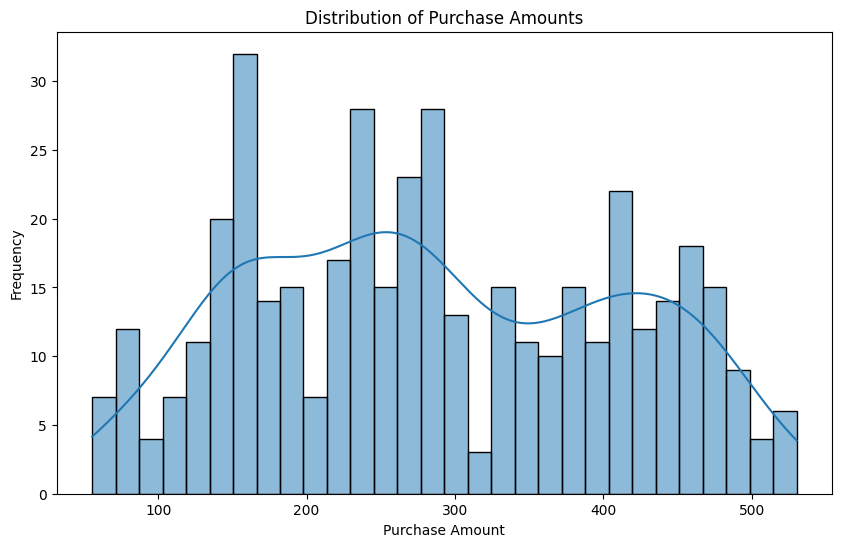

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['purchase_amount'], bins=30, kde=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# 3. Feature Selection for Machine Learning

 # a. Identifying highly correlated features using a correlation heatmap

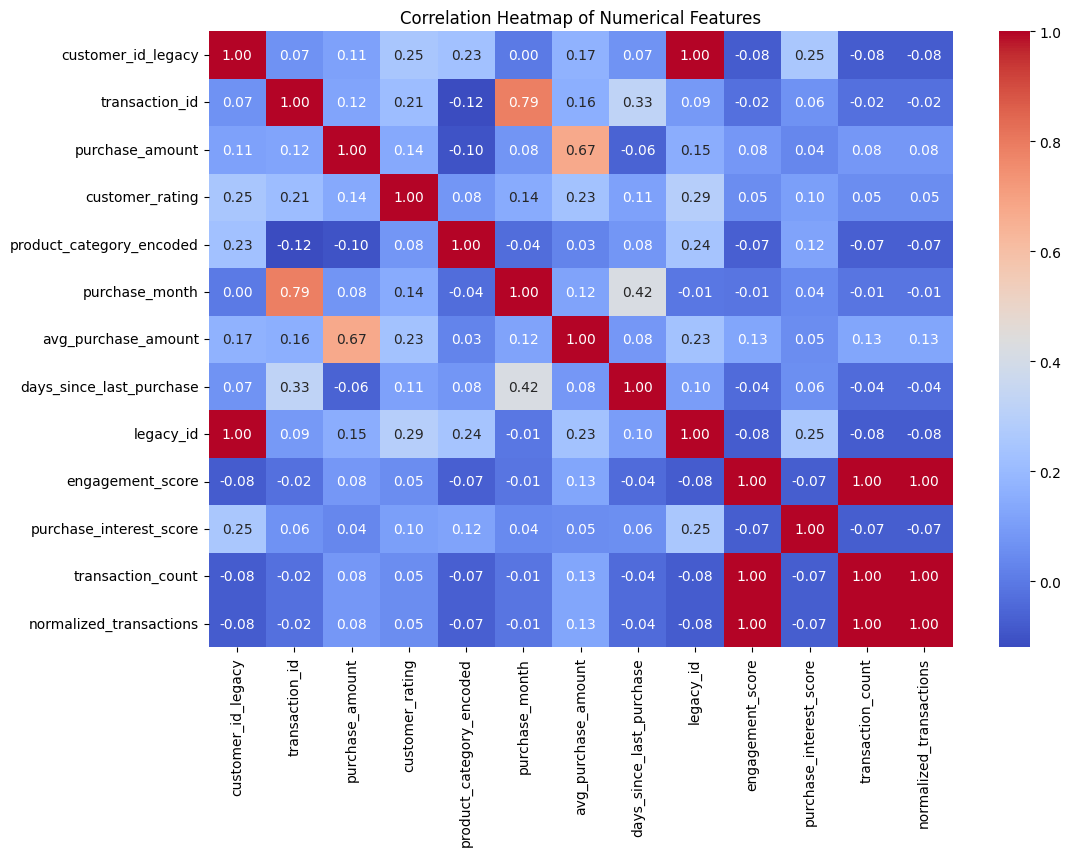

In [47]:
# Correlation heatmap
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()



# b. Selecting top 10 most important features

In [48]:
# Selecting the top 10 most important features using a feature selection algorithm.

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Creating a copy of the DataFrame after dropping NaNs
df_ml = df.dropna().copy()

# Encoding categorical columns
le = LabelEncoder()
for col in ['product_category', 'social_media_platform', 'review_sentiment']:
    df_ml.loc[:, col] = le.fit_transform(df_ml[col])

# Definining features (X) and target (y) and dropping all non-numeric identifier columns
X = df_ml.drop(columns=['purchase_amount', 'customer_id_legacy', 'transaction_id',
                        'purchase_date', 'customer_id_new', 'legacy_id'])
y = df_ml['purchase_amount']

# Fit Random Forest and getting feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Features:\n", importances.head(10))

Top 10 Features:
 avg_purchase_amount         0.496246
customer_rating             0.183520
days_since_last_purchase    0.086949
product_category_encoded    0.067352
purchase_month              0.067306
product_category            0.019747
transaction_count           0.016026
normalized_transactions     0.015787
engagement_score            0.014143
purchase_interest_score     0.013929
dtype: float64


# Final Data Export

In [50]:
df.to_csv('final_dataset_ready_7.csv', index=False)
print("Dataset saved as 'final_dataset_ready_7.csv'")

Dataset saved as 'final_dataset_ready_7.csv'
